In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import tqdm
import xgboost as xgb
warnings.filterwarnings("ignore")
from numpy.random import seed
from sklearn.metrics import mean_squared_error
seed(1)

In [ ]:
demand_data_final=pd.read_csv("./data/demand_train_final.csv")
demand_data=pd.read_csv("./data/demand_train.csv")
demand_data=demand_data_final.append(demand_data)
demand_data['过账日期'] = pd.to_datetime(demand_data['过账日期'])

stock_data_final=pd.read_csv("./data/stock_train_final.csv")
stock_data=pd.read_csv("./data/stock_train.csv")
stock_data=stock_data.append(stock_data_final)
stock_data["过账日期"]=pd.to_datetime(stock_data["过账日期"])

In [ ]:
stock_kind=stock_data.copy()

In [ ]:
stock_kind["需求量"]=demand_data["需求量"].mean()

In [ ]:
stock_kind[["工厂编码","物料编码","过账日期"]]

,工厂编码,物料编码,过账日期
0,2000,1001,2018-01-24
1,2000,1003,2018-01-24
2,2000,1014,2018-01-24
3,2000,1021,2018-01-24
4,2000,1027,2018-01-24
...,...,...,...
16033,2015,1090,2021-02-24
16034,2015,1091,2021-02-24
16035,2015,1252,2021-02-24
16036,2015,1298,2021-02-24


In [ ]:
'''注意:部分物料种类只分布在stok_train里面,需进行合并'''
demand_data=pd.merge(stock_kind[["工厂编码","物料编码","过账日期","物料品牌","物料类型","物料品类"]].drop_duplicates(),demand_data,on=["工厂编码","物料编码","过账日期","物料品牌","物料类型","物料品类"],how="outer")
demand_data=demand_data.fillna(demand_data.mean())

In [88]:
len(test_data.groupby(["工厂编码","物料编码"]).groups)

970

In [87]:
test_data

,过账日期,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2021-03-01,2001.0,1000.0,5000.0,3002.0,4014.0
1,2021-03-02,2001.0,1000.0,5000.0,3002.0,4014.0
2,2021-03-03,2001.0,1000.0,5000.0,3002.0,4014.0
3,2021-03-04,2001.0,1000.0,5000.0,3002.0,4014.0
4,2021-03-05,2001.0,1000.0,5000.0,3002.0,4014.0
...,...,...,...,...,...,...
87,2021-05-27,2001.0,1303.0,5006.0,3002.0,4010.0
88,2021-05-28,2001.0,1303.0,5006.0,3002.0,4010.0
89,2021-05-29,2001.0,1303.0,5006.0,3002.0,4010.0
90,2021-05-30,2001.0,1303.0,5006.0,3002.0,4010.0


In [ ]:
'''对工厂编码、物料编码、过账日期相同的数据进行合并'''
demand_data_gp=demand_data.groupby(["工厂编码","物料编码","过账日期"])
deamnd_drop_dunplicates=pd.DataFrame()
for group in demand_data_gp.groups:
    temp_df=demand_data_gp.get_group(group)
    group_df=pd.DataFrame(temp_df.mean()).T
    group_df["过账日期"]=list(temp_df.head(1)["过账日期"])
    deamnd_drop_dunplicates=deamnd_drop_dunplicates.append(group_df)
demand_data=deamnd_drop_dunplicates

In [ ]:
#%%
'''读取数据并填充缺失日期'''
# 需要把初赛、决赛数据合并(todo)
'''生成test_data'''
test_from_date="2021-03-01"
test_end_date="2021-05-31"
test_date_index=pd.date_range(test_from_date,test_end_date)
test_data=pd.DataFrame()
#%%
demand_data=demand_data.sort_values(by='过账日期', ascending=True)
product_gp=demand_data.sort_values("过账日期").groupby(["物料编码","工厂编码"],as_index=False)
stock_gp=stock_data.sort_values("过账日期").groupby(["物料编码","工厂编码"],as_index=False)
train_from_date="2018-01-01"
train_end_date="2021-02-28"
date_index=pd.date_range(train_from_date,train_end_date)
date_df=pd.DataFrame()
date_df["过账日期"]=date_index
demand_filldate=pd.DataFrame()
for group in tqdm.tqdm(product_gp.groups):
    temp_df=product_gp.get_group(group)
    fd_names=["工厂编码","物料编码","物料品牌","物料类型","物料品类"]
    #  填充空白日期
    merged_df=pd.DataFrame()
    merged_df["过账日期"]=date_df["过账日期"]
    for fd_name in fd_names:
        merged_df[fd_name]=[list(temp_df[fd_name])[0]]*len(merged_df)
    demand_filldate=demand_filldate.append(pd.merge(merged_df,temp_df,how="left").fillna(0))
    
for group in tqdm.tqdm(stock_gp.groups):    
    #  生成test_data
    temp_df=product_gp.get_group(group)
    temp_test_df=pd.DataFrame()
    temp_test_df["过账日期"]=test_date_index
    for fd_name in fd_names:
        temp_test_df[fd_name]=[list(temp_df[fd_name])[0]]*len(temp_test_df)
    test_data=test_data.append(temp_test_df)
    
demand_data=demand_filldate
demand_data=demand_data.fillna(0)

100%|██████████| 970/970 [00:04<00:00, 231.66it/s]


In [ ]:
demand_data.sort_values("过账日期")

,过账日期,工厂编码,物料编码,物料品牌,物料类型,物料品类,需求量
0,2018-01-01,2001.0,1000.0,5000.0,3002.0,4014.0,0.0
0,2018-01-01,2003.0,1048.0,5001.0,3002.0,4014.0,0.0
0,2018-01-01,2013.0,1042.0,5001.0,3002.0,4006.0,0.0
0,2018-01-01,2000.0,1147.0,5010.0,3003.0,4011.0,0.0
0,2018-01-01,2012.0,1038.0,5001.0,3002.0,4006.0,0.0
...,...,...,...,...,...,...,...
1154,2021-02-28,2015.0,1253.0,5000.0,3002.0,4013.0,0.0
1154,2021-02-28,2006.0,1010.0,5000.0,3002.0,4013.0,0.0
1154,2021-02-28,2002.0,1031.0,5001.0,3002.0,4010.0,0.0
1154,2021-02-28,2007.0,1066.0,5007.0,3002.0,4013.0,0.0


In [ ]:
demand_data.to_csv("./data/filldate_demand_data.csv",index=False)

In [ ]:
test_data.to_csv("./data/test_data.csv",index=False)

In [ ]:
daily_sales = demand_data.groupby('过账日期', as_index=False)['需求量'].sum()
store_daily_sales = demand_data.groupby(['工厂编码', '过账日期'], as_index=False)['需求量'].sum()
item_daily_sales = demand_data.groupby(['物料编码', '过账日期'], as_index=False)['需求量'].sum()

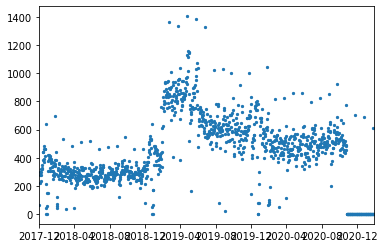

In [ ]:
# 所有工厂总的需求量随日期变化趋势
plt.xlim(daily_sales['过账日期'].min().date(),daily_sales['过账日期'].max().date())
plt.scatter(x=daily_sales["过账日期"],y=daily_sales["需求量"],s=5)

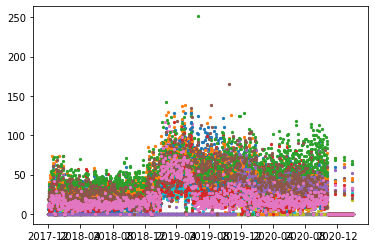

In [ ]:
'''不同工厂的需求量随时间的变化'''
for store in store_daily_sales["工厂编码"].unique():
    current_store_daily_sales=store_daily_sales[store_daily_sales["工厂编码"]==store]
    plt.scatter(x=current_store_daily_sales["过账日期"],y=current_store_daily_sales["需求量"],s=5)

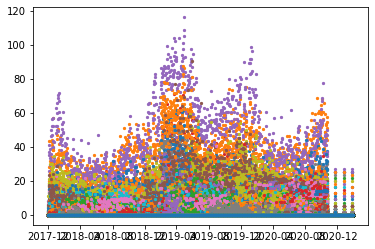

In [ ]:
'''不同物料随时间的变化'''
for item in item_daily_sales["物料编码"].unique():
    current_item_daily_sales=item_daily_sales[item_daily_sales["物料编码"]==item]
    plt.scatter(x=current_item_daily_sales["过账日期"],y=current_item_daily_sales["需求量"],s=5)

In [ ]:
temp_gp=stock_data_final.append(stock_data).groupby(["过账日期","工厂编码","物料编码"])
stock_merge_data=pd.DataFrame()
for group in temp_gp.groups:
    temp_df=temp_gp.get_group(group)
    mean_df=pd.DataFrame(temp_df.mean()).T
    mean_df["过账日期"]=list(temp_df.head(1)["过账日期"])
    stock_merge_data=stock_merge_data.append(mean_df)

In [ ]:
stock_merge_data

,工厂编码,物料编码,物料品牌,物料类型,物料品类,库存量,过账日期
0,2000.0,1001.0,5000.0,3002.0,4006.0,2.680,2018-01-24
0,2000.0,1003.0,5000.0,3002.0,4005.0,7.595,2018-01-24
0,2000.0,1014.0,5000.0,3002.0,4008.0,1.390,2018-01-24
0,2000.0,1021.0,5000.0,3002.0,4006.0,1.105,2018-01-24
0,2000.0,1027.0,5001.0,3002.0,4014.0,2.695,2018-01-24
...,...,...,...,...,...,...,...
0,2015.0,1090.0,5010.0,3002.0,4006.0,3.980,2021-02-24
0,2015.0,1091.0,5010.0,3002.0,4010.0,168.660,2021-02-24
0,2015.0,1252.0,5001.0,3002.0,4013.0,5.250,2021-02-24
0,2015.0,1298.0,5000.0,3002.0,4010.0,20.670,2021-02-24


In [ ]:
stock_data_gp=stock_data.groupby(["工厂编码","物料编码"])
fill_stock_data=pd.DataFrame()
for group in stock_data_gp.groups:
    temp_df=stock_data_gp.get_group(group)
    temp_df2=pd.merge(temp_df,date_df)
    fill_stock_data=fill_stock_data.append(pd.merge(date_df,temp_df,how="left").fillna(temp_df.mean()))

In [ ]:
fill_stock_data.to_csv("./data/fill_stock.csv",index=False)

In [ ]:
demand_stock_data=pd.merge(demand_data,fill_stock_data,on=["过账日期","工厂编码","物料编码","物料类型","物料品类"])

In [ ]:
demand_stock_data.to_csv("./data/demand_stock_data.csv",index=False)

In [ ]:
pd.merge(test_data,fill_stock_data,on=["过账日期","工厂编码","物料编码","物料类型","物料品类","物料品牌"])

In [ ]:
test_data.tail()

In [2]:
pophet_pred=pd.read_csv("./result/11_18_prphet_pred.csv")

In [7]:
pophet_pred

,工厂编码,物料编码,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
0,2001.0,1000.0,3.711901,3.782044,3.749576
1,2002.0,1000.0,2.295045,2.282387,2.805198
2,2004.0,1000.0,3.144809,4.106166,1.382650
3,2005.0,1000.0,0.000000,0.000000,0.000000
4,2006.0,1000.0,2.338035,2.409647,2.376728
...,...,...,...,...,...
966,2015.0,1300.0,1.729181,1.848607,1.968838
967,2005.0,1301.0,1.483682,1.587813,1.727457
968,2011.0,1301.0,1.483682,1.587813,1.727457
969,2001.0,1302.0,0.377447,0.418775,0.429223


In [2]:
xgb_predd=pd.read_csv("./result/11_18_xgb_pred.csv")

In [3]:
temp=xgb_predd["工厂编码"].copy()
xgb_predd["工厂编码"]=xgb_predd["物料编码"]
xgb_predd["物料编码"]=temp

In [5]:
xgb_predd.to_csv("./result/11_22_xgb_pred.csv",index=False)

In [16]:
pd.merge(pophet_pred,xgb_predd,on=["物料编码","工厂编码"])

,工厂编码,物料编码,M+1月预测需求量_x,M+2月预测需求量_x,M+3月预测需求量_x,M+1月预测需求量_y,M+2月预测需求量_y,M+3月预测需求量_y
0,2001.0,1000.0,3.711901,3.782044,3.749576,0.338610,0.140802,0.439123
1,2002.0,1000.0,2.295045,2.282387,2.805198,0.006128,0.000000,0.051980
2,2004.0,1000.0,3.144809,4.106166,1.382650,0.198140,0.473892,0.477779
3,2005.0,1000.0,0.000000,0.000000,0.000000,0.008855,0.000000,0.000000
4,2006.0,1000.0,2.338035,2.409647,2.376728,0.000000,0.161047,0.104888
...,...,...,...,...,...,...,...,...
965,2015.0,1300.0,1.729181,1.848607,1.968838,0.000000,0.000000,0.000000
966,2005.0,1301.0,1.483682,1.587813,1.727457,0.000000,0.000000,0.000000
967,2011.0,1301.0,1.483682,1.587813,1.727457,0.000000,0.000000,0.000000
968,2001.0,1302.0,0.377447,0.418775,0.429223,0.000000,0.000000,0.052887


In [17]:
xgb_predd.colums=["物料编码","工厂编码","M+1月预测需求量","M+2月预测需求量","M+3月预测需求量"]

In [8]:
pophet_pred

,工厂编码,物料编码,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
0,2001.0,1000.0,1.751252,2.430545,1.879023
1,2002.0,1000.0,0.583432,0.599139,1.064881
2,2004.0,1000.0,1.026757,1.611361,0.000000
3,2005.0,1000.0,0.000000,0.000000,0.000000
4,2006.0,1000.0,2.401192,1.953629,1.860291
...,...,...,...,...,...
957,2006.0,1293.0,0.000000,0.000000,0.000000
958,2009.0,1294.0,15.758655,12.039934,14.354979
959,2003.0,1295.0,17.266468,2.299083,1.768379
960,2003.0,1296.0,23.734238,42.579505,20.978056


In [18]:
prophet_xgb_df=pd.DataFrame()
prophet_xgb_df[["工厂编码","物料编码"]]=xgb_predd[["工厂编码","物料编码"]]

In [19]:
prophet_xgb_df["M+1月预测需求量"]=(xgb_predd["M+1月预测需求量"]+pophet_pred["M+1月预测需求量"])/2
prophet_xgb_df["M+2月预测需求量"]=(xgb_predd["M+2月预测需求量"]+pophet_pred["M+2月预测需求量"])/2
prophet_xgb_df["M+3月预测需求量"]=(xgb_predd["M+3月预测需求量"]+pophet_pred["M+3月预测需求量"])/2

In [20]:
prophet_xgb_df.to_csv("./result/11_18_prophet_xgb_df.csv",index=False)

In [75]:
prophet_xgb_df.append(prophet_xgb_df.tail(8)).to_csv("./result/temp_sub.csv",index=False)

In [1]:
len(demand_data.groupby(["工厂编码","物料编码"]).groups)

NameError: name 'demand_data' is not defined

In [5]:
len(stock_data.groupby(["工厂编码","物料编码"]).groups)

970

In [6]:
import pandas as pd
temp_df=pd.read_csv("./result/11_18_prphet_pred.csv")
pd.merge(stock_data,temp_df,on=["工厂编码","物料编码"],how="left").fillna(temp_df.mean())

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,过账日期,工厂编码,物料编码,物料品牌,物料类型,物料品类,库存量,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
0,2018-01-24,2000,1001,5000,3002,4006,2.71,0.000000,3.500847,0.000000
1,2018-01-24,2000,1003,5000,3002,4005,6.84,59.397312,58.244215,68.579935
2,2018-01-24,2000,1014,5000,3002,4008,1.28,0.583174,0.000000,0.000000
3,2018-01-24,2000,1021,5000,3002,4006,1.04,0.000000,0.000000,0.000000
4,2018-01-24,2000,1027,5001,3002,4014,2.63,1.222298,0.007693,0.000320
...,...,...,...,...,...,...,...,...,...,...
30964,2021-02-24,2015,1090,5010,3002,4006,3.98,8.769987,8.683490,10.891088
30965,2021-02-24,2015,1091,5010,3002,4010,168.66,36.079634,35.337076,28.205403
30966,2021-02-24,2015,1252,5001,3002,4013,5.25,0.000000,1.694213,1.094473
30967,2021-02-24,2015,1298,5000,3002,4010,20.67,9.029361,8.791972,8.830387
